In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

csv = './linear.csv'
data = np.genfromtxt(csv,delimiter=',')
X = data[:,1:]
Y = data[:,0]

n = X.shape[0]
d = X.shape[1]

learn_rate = 0.5

## Gradient Descent

In [3]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None,d], name='x')
y = tf.placeholder(tf.float32, [None], name='y')
y_reshaped = tf.reshape(y, [-1,1])
with tf.name_scope("gd"):
    w = tf.get_variable('weights', shape=[d,1], initializer=tf.zeros_initializer)
    b = tf.get_variable('bias', shape=[], initializer=tf.random_normal_initializer)
loss = tf.reduce_sum((tf.square(tf.matmul(x,w) + b - y_reshaped)))/2/n #Mean-square Regression
grad_loss = tf.gradients(loss,[w,b])

train_op1 = w.assign(w - tf.scalar_mul(0.5,grad_loss[0]))
train_op2 = b.assign(b - tf.scalar_mul(0.5,grad_loss[1]))

[[-0.57392067]
 [ 1.3575705 ]
 [ 0.01527568]
 [-0.81375223]] [[-0.57392067]
 [ 1.3575705 ]
 [ 0.01527568]
 [-0.81375223]] -1.0691285


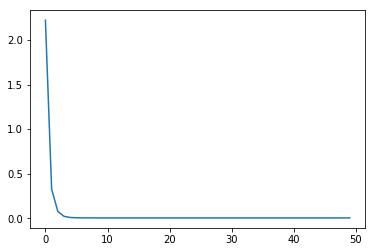

In [4]:
n_epoch = 50
losses_list = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_epoch):
        act_w,w_out,b_out,loss_out = sess.run([w,train_op1,train_op2,loss],feed_dict={x:X,y:Y})
#         print(weight,grad_loss_out,loss_out)
        losses_list.append(loss_out)
    print(act_w,w_out,b_out)
plt.plot(range(n_epoch),losses_list)

## Exact Solution

In [4]:
X_tf = tf.convert_to_tensor(X)
Y_tf = tf.reshape(tf.convert_to_tensor(Y),[n,1])

In [5]:
xtx_inv = tf.matrix_inverse(tf.matmul(X_tf,X_tf,True))
xty = tf.matmul(X_tf,Y_tf,True)
opt_w = tf.matmul(xtx_inv,xty)

In [6]:
with tf.Session() as sess:
    print(sess.run(opt_w))

[[-0.57392068]
 [ 1.35757059]
 [ 0.01527565]
 [-1.88288076]]


## Sklearn

In [7]:
import sklearn.linear_model as lm
lr = lm.LinearRegression(fit_intercept=False)
lr.fit(X,Y)
lr.coef_
# lr.intercept_

array([-0.57392068,  1.35757059,  0.01527565, -1.88288076])

## Stochastic Gradient Descent

In [8]:
tf.reset_default_graph()
batch_size = 5
n_epoch = 50
data = tf.data.Dataset.from_tensor_slices((X,Y))
data = data.shuffle(buffer_size=1000)
data = data.batch(batch_size)
data = data.repeat(n_epoch)
iterator = tf.data.Iterator.from_structure(data.output_types,data.output_shapes)
next_batch = iterator.get_next()
training_init_op = iterator.make_initializer(data)

In [9]:
x = tf.placeholder(tf.float32, [batch_size,d], name='x')
y = tf.placeholder(tf.float32, [batch_size], name='y')
y_reshaped = tf.reshape(y, [batch_size,1])
with tf.name_scope("sgd"):
    w = tf.get_variable('weights', shape=[d,1], initializer=tf.zeros_initializer)

loss = tf.reduce_sum((tf.square(tf.matmul(x,w) - y_reshaped)))/2/n #Mean-square Regression
grad_loss = tf.gradients(loss,w)

train_op = w.assign(w - tf.scalar_mul(0.5,grad_loss[0]))

In [10]:
y[1]

<tf.Tensor 'strided_slice:0' shape=() dtype=float32>

[[-0.57304054]
 [ 1.3556038 ]
 [ 0.01501258]
 [-1.8834652 ]]


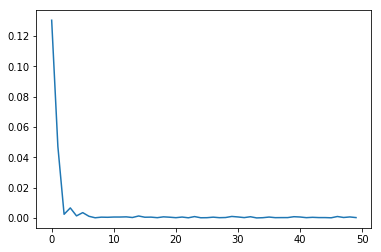

In [11]:
losses_list = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(training_init_op)
    for i in range(n_epoch):
        for i2 in range(n//batch_size):
            X_batch, Y_batch = sess.run(next_batch)
            weight,loss_out = sess.run([train_op,loss],feed_dict={x:X_batch,y:Y_batch})
#         print(weight,grad_loss_out,loss_out)
        losses_list.append(loss_out)
    print(weight)
plt.plot(range(n_epoch),losses_list)